In [10]:
%config SqlMagic.autopandas=True

# mnist demo

In [22]:
def show_digit(img):
    plt.imshow(np.reshape(img, (28, 28)), cmap='gray')
    
def guess_digit(img):
    cur.execute("select madlib.multiclass_predict(state, "
                "%s::double precision[]) from mnist_model", (img, ))
    return cur.fetchall()[0][0]

def estimate_digit(img):
    cur.execute("select madlib.multiclass_score(state, "
                "%s::double precision[], True)::double precision[] from mnist_model", (img, ))
    return np.array(cur.fetchall()[0][0])


In [6]:
%%sql

drop table if exists mnist_model;
create table mnist_model as
select
	state::double precision[] as state,
	(result).coefficients as coef,
	(result).loss as loss,
	(result).n_features as n_features,
	(result).n_classes as n_classes,
	(result).num_rows_processed as num_rows_processed
from (
	select
		state as state,
		madlib.internal_multiclass_result(state::double precision[]) as result
	from (
		select
			madlib.multiclass_step(
	                          ind_var::double precision[][],
	                          dep_var::double precision[],
	                          NULL::double precision[],
	                          784::integer,
	                          10::integer,
	                          5::integer, -- epoch
	                          64::integer, -- batch_size
	                          0.1::double precision,
	                          0.0001::double precision,
	                          1::double precision,
	                          2
	                          ) as state
		from mnist_train) subq
) q;

select
	1 - miss/total as accuracy
from (
	select count(*)::float8 as miss
	from mnist_test, mnist_model
	where madlib.multiclass_predict(state, ind_var) <> dep_var
) q, (select count(*)::float8 as total from mnist_test) q2



Done.
1 rows affected.
1 rows affected.


accuracy
0.868008658009


In [19]:
df_te = %sql select * from mnist_test
N = len(df_te)

23100 rows affected.


In [20]:
idx = np.random.randint(0, N)
label, img = df_te['dep_var'][idx], df_te['ind_var'][idx]

(None, 5)

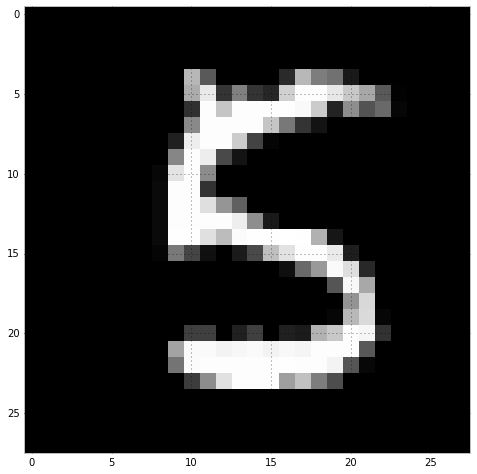

In [23]:
show_digit(img), label

In [24]:
guess_digit(img)

5

# cifar10 demo

In [11]:
cifar = %sql select * from cifar_test

10000 rows affected.


In [12]:
imgs, labels = cifar['ind_var'], cifar['dep_var']

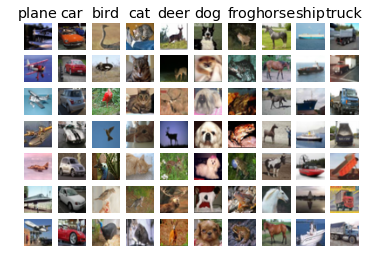

In [13]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(labels == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(np.array(imgs[idx]).reshape(32, 32, 3).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

In [14]:
%%sql

drop table if exists cifar_model;
create table cifar_model as
select
	state::double precision[] as state,
	(result).coefficients as coef,
	(result).loss as loss,
	(result).n_features as n_features,
	(result).n_classes as n_classes,
	(result).num_rows_processed as num_rows_processed
from (
	select
		state as state,
		madlib.internal_multiclass_result(state::double precision[]) as result
	from (
		select
			madlib.multiclass_step(
	                          ind_var::double precision[][],
	                          dep_var::double precision[],
	                          NULL::double precision[],
	                          3072::integer,
	                          10::integer,
	                          3::integer, -- epoch
	                          64::integer, -- batch_size
	                          0.01::double precision,
	                          0.0001::double precision,
	                          1::double precision,
	                          2
	                          ) as state
		from cifar_train) subq
) q;



Done.
1 rows affected.


""


In [15]:
model = np.array([np.array(x) for x in to_df(cur, 'cifar_model')['coef'][0]])

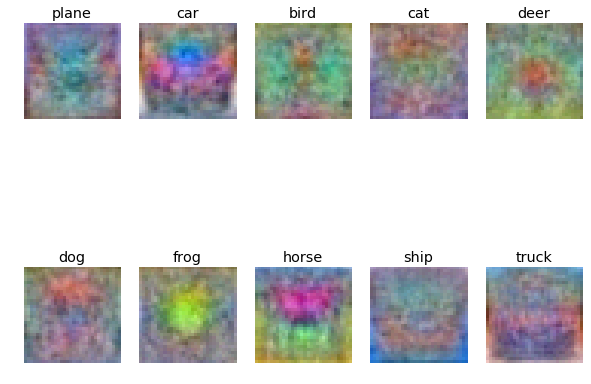

In [18]:
w = model.T
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])